In [1]:
import sys
sys.version

'3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)]'

# 平行多导线系统参数计算函数(Carson简化法计算zii 考虑集肤效应）

文件名： conductors_calc_para(r').pynb
日期： 2019.02.10
编写人： 朱明

 ## 多导线原始参数
 
 **牵引网导线架设横截面示意图**

  ![%E5%A4%8D%E7%BA%BFAT%E5%AF%BC%E7%BA%BF%E7%A9%BA%E9%97%B4%E5%88%86%E5%B8%83%E5%9B%BE.vsd.jpg](attachment:%E5%A4%8D%E7%BA%BFAT%E5%AF%BC%E7%BA%BF%E7%A9%BA%E9%97%B4%E5%88%86%E5%B8%83%E5%9B%BE.vsd.jpg)   




** 导线编号：**
 
|导线号 | 导线代码 | 导线名称 |
|:---|:---|:---|
|01|CW1|接触导线1|
|02|MW1|承力索1|
|03|PF1|正馈线1|
|04|RA1|钢轨1|
|05|RA2|钢轨2|
|06|PW1|保护线1|
|07|E1|综合地线1|
|08|CW2|接触导线2|
|09|MW2|承力索2|
|10|PF2|正馈线2|
|11|RA3|钢轨3|
|12|RA4|钢轨4|
|13|PW2|保护线2|
|14|E2|综合地线2|
  
 


** 导线架设截面坐标：**

conductors_coordinater=0.001*np.array([[0,6300],[0,7500],[-4400,8500],[-755,1000],[755,1000],[-3600,8000],[-4400,500],
                                 [5000,6300],[5000,7500],[4400+5000,8500],[4245,1000],[5755,1000],[3600+5000,8000],
                                 [4400+5000,500]],np.float64)  # 多导体坐标数组 (x,y),单位 m

** 导线计算半径：**
conductors_calc_radius=0.001*np.array([5.9,7.00,9.5,109.1,109.1,7.60,5.35,5.9,7.00,9.5,109.1,109.1,7.60,5.35])
                                    #多导体计算半径，单位 m， 计算电位系数用
** 导线等效半径：**
conductors_equivalent_radius=0.001*np.array([6.18,4.74,9.03,49.65,49.65,7.22,4.055,6.18,4.74,9.03,49.65,49.65,7.22,4.055])
                                    #多导体等效半径,单位m, 计算自电感用
** 导线直流电阻：**
conductors_resistance=np.array([0.146,0.158,0.163,0.135,0.135,0.255,0.28,0.146,0.158,0.163,0.135,0.135,0.255,0.28])
                                    #多导体直流电阻，单位 欧/km
                                    
  ** 导线电阻率：**
conductors_rho=10**-10*np.array([176.67,146.15,298.96,10405.8,10405.8,352.74,251.77,176.67,146.15,298.96,10405.8,10405.8,352.74,251.77]）计算方法：rho=RS/L（R为直流电阻，S根据导线型号查出截面半径，L=1m。单位 米）
{原始参数在软件开发前期用数组形式给出，在后阶段以数据文件的形式存储，通过读取数据生成变量。}

In [2]:
import numpy as np
import math
from scipy import linalg
from scipy import constants as C
from scipy import special

#导线定义

"""
1. 接触线（CW1）; 2.承力索（MW1）; 3.正馈线（PF1）; 4.钢轨1（RA1）;5.钢轨2（RA2）;6.保护线（PW1）;7.综合地线（E1）
8. 接触线（CW2）; 9.承力索（MW2）; 10.正馈线（PF2）; 11.钢轨3（RA3）;12.钢轨4（RA4）;13.保护线（PW2）;14.综合地线（E2）

"""
conductors_coordinater=0.001*np.array([[0,6300],[0,7500],[-4400,8500],[-755,1000],[755,1000],[-3600,8000],[-4400,500],
                                 [5000,6300],[5000,7500],[4400+5000,8500],[4245,1000],[5755,1000],[3600+5000,8000],
                                 [4400+5000,500]],np.float64)  # 多导体坐标数组 (x,y),单位 m

conductors_calc_radius=0.001*np.array([5.9,7.00,9.5,109.1,109.1,7.60,5.35,5.9,7.00,9.5,109.1,109.1,7.60,5.35])
                                    #多导体计算半径，单位 m， 计算电位系数用

conductors_equivalent_radius=0.001*np.array([4.6,4.74,9.03,49.65,49.65,7.22,4.055,4.6,4.74,9.03,49.65,49.65,7.22,4.055])
                                    #多导体等效半径,单位m, 计算自电感用


conductors_resistance=np.array([0.146,0.158,0.163,0.135,0.135,0.255,0.28,0.146,0.158,0.163,0.135,0.135,0.255,0.28])
                                    #多导体直流电阻，单位 欧/km
#conductors_rho=10**-10*np.array([159.66,243.22,462.15,50481.60,50481.60,462.72,251.77,159.66,243.22,462.15,50481.60,50481.60,462.72,251.77])、、S用πr**2的方法计算
#conductors_rho=10**-10*np.array([176.67,146.15,298.96,10405.8,10405.8,352.74,251.77,176.67,146.15,298.96,10405.8,10405.8,352.74,251.77])
conductors_rho=10**-10*np.array([55.8,54.05,28.33,2100,2100,28.33,54.05,55.8,54.05,28.33,2100,2100,28.33,54.05])
conductors_coordinater,conductors_calc_radius,conductors_equivalent_radius,conductors_resistance,conductors_rho

(array([[ 0.   ,  6.3  ],
        [ 0.   ,  7.5  ],
        [-4.4  ,  8.5  ],
        [-0.755,  1.   ],
        [ 0.755,  1.   ],
        [-3.6  ,  8.   ],
        [-4.4  ,  0.5  ],
        [ 5.   ,  6.3  ],
        [ 5.   ,  7.5  ],
        [ 9.4  ,  8.5  ],
        [ 4.245,  1.   ],
        [ 5.755,  1.   ],
        [ 8.6  ,  8.   ],
        [ 9.4  ,  0.5  ]]),
 array([0.0059 , 0.007  , 0.0095 , 0.1091 , 0.1091 , 0.0076 , 0.00535,
        0.0059 , 0.007  , 0.0095 , 0.1091 , 0.1091 , 0.0076 , 0.00535]),
 array([0.0046  , 0.00474 , 0.00903 , 0.04965 , 0.04965 , 0.00722 ,
        0.004055, 0.0046  , 0.00474 , 0.00903 , 0.04965 , 0.04965 ,
        0.00722 , 0.004055]),
 array([0.146, 0.158, 0.163, 0.135, 0.135, 0.255, 0.28 , 0.146, 0.158,
        0.163, 0.135, 0.135, 0.255, 0.28 ]),
 array([5.580e-09, 5.405e-09, 2.833e-09, 2.100e-07, 2.100e-07, 2.833e-09,
        5.405e-09, 5.580e-09, 5.405e-09, 2.833e-09, 2.100e-07, 2.100e-07,
        2.833e-09, 5.405e-09]))

## 电位系数矩阵计算
  **函数名：  calc_potential_coefficient(c_xy,r)** 
  
 * parameters:    
       1. c_xy:  2×n维数组，多导线的坐标（x,y）,单位m;  
       2. r:     1×n维数组，导线的半径,单位 m  
 * Return:
       1. P:     n×n维数组，电位系数   
 * 功能：        计算多导体的电位系数矩阵P。 
 
  计算公式：  
  
   $$ P_{ii}=\frac{1}{2\pi\epsilon}ln\frac{2h_{i}}{r_i}=18 ×10^9ln\frac{2h_{i}}{r_i}$$
   
   $$ P_{ij}=\frac{1}{2\pi\epsilon}ln\frac{D_{ij}}{d_{ij}}=18 ×10^9ln\frac{D_{ij}}{d_{ij}}  ~~~~ (i≠j) $$
   
   
   
  ![ 导体镜像截面图](/AT_calc/images/conductors_section.png "")
  
  ![conductors_section.png](attachment:conductors_section.png)
  

In [3]:
def calc_potential_coefficient(c_xy,r):
    """ 计算电位系数矩阵P
    """
  #  epsilon0=1/(36*np.pi)*10**-9         #空气介电系数
   # c_xy=conductors_coordinater          # 多导体坐标数组 (x,y),单位 m
   # R=conductors_calc_radius             #多导体计算半径，单位 m， 计算电位系数用
    n=np.shape(c_xy)[0]
    P=np.empty((n,n),np.float64)
    for i in range(n):
        for j in range(n):
            if i==j:
                P[i,i]=18*10**+9*np.log(2*c_xy[i,1]/r[i])
            else:
                Dij=np.sqrt((c_xy[i,0]-c_xy[j,0])**2+(c_xy[i,1]+c_xy[j,1])**2)
                dij=np.sqrt((c_xy[i,0]-c_xy[j,0])**2+(c_xy[i,1]-c_xy[j,1])**2)
                P[i,j]=18*10**+9*np.log(Dij/dij)
    return P
#r=conductors_equivalent_radius
r=conductors_calc_radius
c_xy=conductors_coordinater
P=calc_potential_coefficient(c_xy,r)
print(P)

[[1.37996995e+11 4.39622466e+10 2.05883757e+10 5.67796731e+09
  5.67796731e+09 2.35691949e+10 1.91955404e+09 1.79527926e+10
  1.88802399e+10 1.07406190e+10 3.92405879e+09 3.10313444e+09
  1.15864474e+10 8.84577352e+08]
 [4.39622466e+10 1.38058116e+11 2.34405643e+10 4.77886607e+09
  4.77886607e+09 2.65792056e+10 1.78542648e+09 1.88802399e+10
  2.07232658e+10 1.21411302e+10 3.63573517e+09 3.01561698e+09
  1.29884638e+10 9.32768325e+08]
 [2.05883757e+10 2.34405643e+10 1.34814183e+11 3.58267191e+09
  3.09555510e+09 5.15304234e+10 2.12009464e+09 1.07406190e+10
  1.21411302e+10 8.30953415e+09 2.07693122e+09 1.74035222e+09
  8.62411227e+09 5.82084618e+08]
 [5.67796731e+09 4.77886607e+09 3.58267191e+09 5.23554762e+10
  9.11849942e+09 4.00493522e+09 1.24026184e+09 3.10313444e+09
  3.01561698e+09 1.74035222e+09 1.33578005e+09 8.11724179e+08
  1.89529958e+09 1.72461978e+08]
 [5.67796731e+09 4.77886607e+09 3.09555510e+09 9.11849942e+09
  5.23554762e+10 3.47240187e+09 6.47201697e+08 3.92405879e+09


In [4]:
def calc_Y(f,c_xy,r):
    P = calc_potential_coefficient(c_xy,r)
    B=linalg.inv(P)#矩阵求逆
    Y= 1j*2*np.pi*f*B
    return Y
r=conductors_calc_radius
c_xy=conductors_coordinater
f=50
Y=calc_Y(f,c_xy,r)
print('Y矩阵(×e-12) : \n {}'.format(Y*10**12))

Y矩阵(×e-12) : 
 [[0.+2.62214338e+03j 0.-7.04065188e+02j 0.-1.57141134e+02j
  0.-1.45038553e+02j 0.-1.41389466e+02j 0.-2.11997678e+02j
  0.-2.49875083e+01j 0.-1.39763073e+02j 0.-1.44838341e+02j
  0.-4.83088952e+01j 0.-7.85278871e+01j 0.-4.65049115e+01j
  0.-5.26635246e+01j 0.-5.58039650e+00j]
 [0.-7.04065188e+02j 0.+2.65512271e+03j 0.-2.08761736e+02j
  0.-8.97027505e+01j 0.-8.70419128e+01j 0.-2.69198237e+02j
  0.-1.88990495e+01j 0.-1.44838341e+02j 0.-1.79657365e+02j
  0.-6.77054258e+01j 0.-5.73768103e+01j 0.-3.85988526e+01j
  0.-7.02654966e+01j 0.-5.78843969e+00j]
 [0.-1.57141134e+02j 0.-2.08761736e+02j 0.+2.77255116e+03j
  0.-6.28645720e+01j 0.-4.04563688e+01j 0.-9.50588473e+02j
  0.-2.99270336e+01j 0.-4.83088952e+01j 0.-6.77054258e+01j
  0.-4.23855105e+01j 0.-1.95644967e+01j 0.-1.35525435e+01j
  0.-3.87492983e+01j 0.-2.67469792e+00j]
 [0.-1.45038553e+02j 0.-8.97027505e+01j 0.-6.28645720e+01j
  0.+6.22537699e+03j 0.-1.03917952e+03j 0.-7.71412895e+01j
  0.-6.57304721e+01j 0.-4.65049115e+

 
  ** 函数名: merge_potential_coefficient(P,m,k)**
 * parameters:    
       1. P:      n×n 维数组，电位系数 ;  
       2. m:      第 m 号导线（导线序号从0开始）；
       3. k:      第 k 号导线，m＜k≤n,
 * Return:
       1. P:      n-1×n-1 维数组，归并后的电位系数   
   
 * 功能：         导线k并入导线m,计算修正后的电位系数P
 
  导线k并入m公式推导：
 
 \begin{equation} 
 \begin{bmatrix}
  u_1\\
  \vdots\\
  u_m\\
  \vdots\\
  u_k\\
  \vdots\\
  u_n
  \end{bmatrix} =
  \begin{bmatrix}
  P_{11}&\dots& P_{1m}&\dots&P_{1k}&\dots&P_{1n}\\
  \vdots& &\vdots& &\vdots& &\vdots\\
  P_{m1}&\dots& P_{mm}&\dots&P_{mk}&\dots&P_{mn}\\
   \vdots& &\vdots& &\vdots& &\vdots\\
    P_{k1}&\dots& P_{km}&\dots&P_{kk}&\dots&P_{kn}\\
   \vdots& &\vdots& &\vdots& &\vdots\\ 
    P_{n1}&\dots& P_{nm}&\dots&P_{nk}&\dots&P_{nn}\\
   \end{bmatrix}
   \begin{bmatrix}
   q_1\\
   \vdots\\
  q_m\\
  \vdots\\
  q_k\\
  \vdots\\
  q_n
 \end{bmatrix}
 \end{equation}

令 $q_{m}=q_{m}+q_{k}$ 有： 

\begin{equation} 
 \begin{bmatrix}
  u_1\\
  \vdots\\
  u_m\\
  \vdots\\
  u_k\\
  \vdots\\
  u_n
  \end{bmatrix} =
  \begin{bmatrix}
  P_{11}&\dots& P_{1m}&\dots&(P_{1k}-P_{1m})&\dots&P_{1n}\\
  \vdots& &\vdots& &\vdots& &\vdots\\
  P_{m1}&\dots& P_{mm}&\dots&(P_{mk}-P_{mm})&\dots&P_{mn}\\
  \vdots& &\vdots& &\vdots& &\vdots\\
   P_{k1}&\dots& P_{km}&\dots&(P_{kk}-P_{km})&\dots&P_{kn}\\
  \vdots& &\vdots& &\vdots& &\vdots\\ 
   P_{n1}&\dots& P_{nm}&\dots&(P_{nk}-P_{nm})&\dots&P_{nn}\\
  \end{bmatrix}
  \begin{bmatrix}
   q_1\\
   \vdots\\
  q_m+q_k\\
  \vdots\\
  q_k\\
  \vdots\\
  q_n
 \end{bmatrix}
\end{equation}   

P矩阵第k列参数发生变化，修正公式为：$$P_{ik}=P_{ik}-P_{im}$ ( i=0,1,...,n), q_m=q_m+q_k$$.

方程中，$u_{k}-u_{m}=0$,得方程

 \begin{equation*} 
 \begin{bmatrix}
  u_1\\
  \vdots\\
  u_m\\
  \vdots\\
  0\\
  \vdots\\
  u_n
  \end{bmatrix} =
  \begin{bmatrix}
  P_{11}&\dots& P_{1m}&\dots&P_{1k}&\dots&P_{1n}\\
  \vdots& &\vdots& &\vdots& &\vdots\\
  P_{m1}&\dots& P_{mm}&\dots&P_{mk}&\dots&P_{mn}\\
   \vdots& &\vdots& &\vdots& &\vdots\\
    P_{k1}- P_{m1}&\dots& P_{km}-P_{mm}&\dots&P_{kk}-P_{mk}&\dots&P_{kn}-P_{mn}\\
   \vdots& &\vdots& &\vdots& &\vdots\\ 
    P_{n1}&\dots& P_{nm}&\dots&P_{nk}&\dots&P_{nn}\\
   \end{bmatrix}
   \begin{bmatrix}
   q_1\\
   \vdots\\
  q_m\\
  \vdots\\
  q_k\\
  \vdots\\
  q_n
 \end{bmatrix}
\end{equation*}

第k行等式有:
$$ 0= (P_{k1}- P_{m1})q_1+\dots+（P_{km}-P_{mm})q_m+\dots+(P_{kk}-P_{mk})q_k+\dots+(P_{kn}-P_{mn})q_n$$

可以求得：
$$q_k=-\frac{(P_{k1}- P_{m1})}{(P_{kk}-P_{mk})}q_1-\dots-\frac{(P_{km}- P_{mm})}{(P_{kk}-P_{mk})}q_m\dots-\frac{(P_{kn}- P_{mn})}{(P_{kk}-P_{mk})}q_n$$

令$K_j=\frac{P_{kj}- P_{mj}}{P_{kk}-P_{mk}}$ (j≠k)，有
$$q_k=-K_1q_1-\dots-K_m q_m-\dots-K_n q_n$$

导线电压$u_i$写成方程有：
$$u_i=P_{i1}q_1+\dots+P_{im}q_m+\dots+P_{ik}q_k+\dots+P_{in}q_n$$

把$q_k$代入方程中，得到
$$u_i=（P_{i1}-P_{ik}K_1)q_1+\dots+(P_{im}-P_{ik}K_m)q_m+\dots+(P_{in}-P_{ik}K_n)q_n$$

取(i,j=0,1,...,n; i≠k;j≠k),可以得到合并矩阵元素$P_{ij}$.
 $$P_{ij}=P_{ij}-P_{ik}K_j=P_{ij}-P_{ik}\frac{P_{kj}- P_{mj}}{P_{kk}-P_{mk}}$$

总之，导线k合并到导线m，P参数的修正步骤归纳如下：

（1）$P_{ik}=P_{ik}-P_{im}$ ( i=0,1,...,n)

（2）$P_{ij}=P_{ij}-P_{ik}K_j=P_{ij}-P_{ik}\frac{P_{kj}- P_{mj}}{P_{kk}-P_{mk}}$ （i,j=0,1,...,n; i≠k;j≠k）

（3）除P中的第k行第k列，P降n-1阶，为合并后n-1根导线的电位系数矩阵。

In [5]:
def merge_potential_coefficient(P,m,k):
    n=np.shape(P)[0]
    for i in range(n):
        P[i,k]=P[i,k]-P[i,m]
         
    for i in range(n):
        for j in range(n):
            if i!=k or j!=k:
                P[i,j]=P[i,j]-(P[k,j]-P[m,j])/(P[k,k]-P[m,k])*P[i,k]
                        
          
    E=np.empty((n-1,n-1),np.float64)
    for i in range(n):
        for j in range(n):
            if i<k:
                if j<k:
                    E[i,j]=P[i,j]
                if j>k:
                    E[i,j-1]=P[i,j]
            if i>k:
                if j<k:
                    E[i-1,j]=P[i,j]
                if j>k:
                    E[i-1,j-1]=P[i,j]
    
    return E

#测试
P=calc_potential_coefficient(conductors_coordinater,conductors_calc_radius)
# P=merge_potential_coefficient(P,0,1) 
# P=merge_potential_coefficient(P,2,3)
# P=merge_potential_coefficient(P,2,3)
# P=merge_potential_coefficient(P,2,3)
# P=merge_potential_coefficient(P,3,4)
# P=merge_potential_coefficient(P,5,6)
# P=merge_potential_coefficient(P,5,6)
# P=merge_potential_coefficient(P,5,6)
P=merge_potential_coefficient(P,0,1)
P=merge_potential_coefficient(P,6,7) 
P=merge_potential_coefficient(P,2,3)
P=merge_potential_coefficient(P,7,8) 
P=merge_potential_coefficient(P,2,3)
P=merge_potential_coefficient(P,6,7) 
P=merge_potential_coefficient(P,2,3)
P=merge_potential_coefficient(P,5,6) 
np.set_printoptions(precision=3,linewidth=214,suppress=True)
print('P矩阵 e+10 : \n {}'.format(P*10**-10))

P矩阵 e+10 : 
 [[ 8.807  1.426  0.715  1.729  0.802  0.402]
 [ 1.426 11.928  0.935  1.056  0.611  0.252]
 [ 0.715  0.935  2.095  0.291  0.142  0.099]
 [ 1.729  1.056  0.291  8.863  1.472  0.725]
 [ 0.802  0.611  0.142  1.472 11.97   0.947]
 [ 0.402  0.252  0.099  0.725  0.947  2.068]]


 
   
   AT牵引网络由14根导线逐步合并成6根导线：
   
  （1） 1. 接触线（CW1）+ 2.承力索（MW1）
  
  （2） 3.正馈线（PF1）
  
  （3） 4.钢轨1（RA1）+5.钢轨2（RA2）+6.保护线（PW1）+7.综合地线（E1）
  
  （4） 8. 接触线（CW2）+ 9.承力索（MW2）
  
  （5） 10.正馈线（PF2）
  
  （6） 11.钢轨3（RA3）+12.钢轨4（RA4）+13.保护线（PW2）+14.综合地线（E2）
  
   
##  电容系数矩阵计算
  函数名： calc_B(P)
  

In [6]:
def calc_B():
    """ 计算电容系数矩阵
    """
    P=calc_potential_coefficient(conductors_coordinater,conductors_calc_radius)
    P=merge_potential_coefficient(P,0,1) 
    P=merge_potential_coefficient(P,2,3)
    P=merge_potential_coefficient(P,2,3)
    P=merge_potential_coefficient(P,2,3)
    P=merge_potential_coefficient(P,3,4)
    P=merge_potential_coefficient(P,5,6)
    P=merge_potential_coefficient(P,5,6)
    P=merge_potential_coefficient(P,5,6)
    B=linalg.inv(P)
    return B
B=calc_B()
np.set_printoptions(precision=3,linewidth=214,suppress=True)              
          
print('B矩阵(×e-12) : \n {}'.format(B*10**12))

B矩阵(×e-12) : 
 [[12.273 -0.979 -3.388 -2.002 -0.389 -1.226]
 [-0.979  8.855 -3.489 -0.68  -0.232 -0.375]
 [-3.388 -3.489 50.569 -0.482 -0.043 -1.149]
 [-2.002 -0.68  -0.482 12.218 -1.067 -3.298]
 [-0.389 -0.232 -0.043 -1.067  8.805 -3.553]
 [-1.226 -0.375 -1.149 -3.298 -3.553 51.488]]


##  理想导体时电感L矩阵计算  

**函数名：calc_L(c_xy,r)**  
* Parameters:
    1. c_xy:      2×n维数组，多导线的坐标（x,y）,单位（m）;  
    2. r:         1×n维数组，导线的半径,单位(m)  
    
* Return:
    1. L:        n×n维数组，多导体和大地为理想导体时的自感$L_{ii}$和互感$L_{ij}$  
    
功能：    计算理想导体时的自感$L_{ii}$和互感$L_{ij}$  

**计算公式：**

导线回路电感 $$L_{ii}=\frac{\mu_0}{2\pi}ln\frac{2h_i}{r_i}=2×10^{-4}ln\frac{2h_i}{r_i}$$
导线回路互感 $$L_{ij}=\frac{\mu_0}{2\pi}ln\frac{D_{ij}}{d_{ij}}=2×10^{-4}ln\frac{D_{ij}}{d_{ij}}$$


In [7]:
def calc_L(c_xy,r):
    n=np.shape(c_xy)[0]
    L=np.empty((n,n),np.float64)
    for i in range(n):           #计算导线外自感和互电感
        for j in range(n):
            if i==j:
                L[i,i]=2*10**-7*np.log(2*c_xy[i,1]/r[i])
            else:
                Dij=np.sqrt((c_xy[i,0]-c_xy[j,0])**2+(c_xy[i,1]+c_xy[j,1])**2) 
                dij=np.sqrt((c_xy[i,0]-c_xy[j,0])**2+(c_xy[i,1]-c_xy[j,1])**2)
                L[i,j]=2*10**-7*np.log(Dij/dij) 
    return L

# 函数测试
f=50
c_xy=conductors_coordinater
r=conductors_calc_radius
L=calc_L(c_xy,r)
np.set_printoptions(precision=4,linewidth=214,suppress=True) 
print('L矩阵(×e-3) : \n {}'.format(L*10**3))


L矩阵(×e-3) : 
 [[0.0015 0.0005 0.0002 0.0001 0.0001 0.0003 0.     0.0002 0.0002 0.0001 0.     0.     0.0001 0.    ]
 [0.0005 0.0015 0.0003 0.0001 0.0001 0.0003 0.     0.0002 0.0002 0.0001 0.     0.     0.0001 0.    ]
 [0.0002 0.0003 0.0015 0.     0.     0.0006 0.     0.0001 0.0001 0.0001 0.     0.     0.0001 0.    ]
 [0.0001 0.0001 0.     0.0006 0.0001 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0001 0.0001 0.     0.0001 0.0006 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0003 0.0003 0.0006 0.     0.     0.0015 0.     0.0001 0.0001 0.0001 0.     0.     0.0001 0.    ]
 [0.     0.     0.     0.     0.     0.     0.001  0.     0.     0.     0.     0.     0.     0.    ]
 [0.0002 0.0002 0.0001 0.     0.     0.0001 0.     0.0015 0.0005 0.0002 0.0001 0.0001 0.0003 0.    ]
 [0.0002 0.0002 0.0001 0.     0.     0.0001 0.     0.0005 0.0015 0.0003 0.0001 0.0001 0.0003 0.    ]
 [0.0001 0.0001 0.0001 0.     0.     0.0001 0.     0.0002 0.0003 0.0015 0.   

## 计算导线内电阻和内电感
**函数名： calc_Zc(f,R,rho)**
* Parameters:
    1. f:       频率（Hz）
    2. R:      导线半径（m）(等效半径） 
    3. rhoi     导线电阻率（Ω/m）
* Return:
    1. Rc:      导线交流电阻（Ω/m）
    2. Xc:      导线交流内电感（H/m）  
    
 功能：计算导线的交流电阻Rc和内电感Lc
 
 实心圆柱体单位长度交流内阻抗为  
 $$ Z_c=\frac{jmρJ_0(nr)}{2\pi J_1(nr)}=\frac{jmρ}{2\pi r}\frac{ber(mr)+jbei(mr)}{ber'(mr)+jbei'(mr)}$$
 式中$n=jm\sqrt j  ,m=\sqrt\frac{ωμ}{ρ}$  
 
 导线内阻一般用上述基于贝塞尔函数的公式计算，如果导线是钢轨，由于是铁磁材质，需要通过用有限元软件计算给出。

In [8]:
def calc_Zc(f,R,mu,rho):
    #n=np.shape(rho)[0]
    #m=np.empty(n,np.float64)
    #Zc=np.empty(n,np.complex128)
    #for i in range(n):
    m=np.sqrt(2*np.pi*f*mu/rho)
    A=1j*m*rho/(2*np.pi*R)
    B=special.ber(m*R)+1j*special.bei(m*R)
    C=special.berp(m*R)+1j*special.beip(m*R)
    Zc=A*B/C
    #print(m) 
    return Zc

#测试
f=50
R=conductors_equivalent_radius          # 单位 m
mu=4*np.pi*10**-7     #
rho=conductors_rho
Zc=calc_Zc(f,R,mu,rho)
print(Zc*10**3)
print(Zc.tolist())

[0.0849+0.0156j 0.0776+0.0156j 0.016 +0.0124j 0.0299+0.0149j 0.0299+0.0149j 0.0212+0.014j  0.1054+0.0156j 0.0849+0.0156j 0.0776+0.0156j 0.016 +0.0124j 0.0299+0.0149j 0.0299+0.0149j 0.0212+0.014j  0.1054+0.0156j]
[(8.491071305089507e-05+1.561720197393702e-05j), (7.76375343385756e-05+1.55991243450224e-05j), (1.5983081526977534e-05+1.2353873135476221e-05j), (2.9902426681558245e-05+1.4906918230284273e-05j), (2.9902426681558245e-05+1.4906918230284273e-05j), (2.121215356489907e-05+1.396266264474747e-05j), (0.00010541326375920289+1.564934106454878e-05j), (8.491071305089507e-05+1.561720197393702e-05j), (7.76375343385756e-05+1.55991243450224e-05j), (1.5983081526977534e-05+1.2353873135476221e-05j), (2.9902426681558245e-05+1.4906918230284273e-05j), (2.9902426681558245e-05+1.4906918230284273e-05j), (2.121215356489907e-05+1.396266264474747e-05j), (0.00010541326375920289+1.564934106454878e-05j)]


## 计算大地与导线回路电阻和电感
**函数名：calc_Zgm(f,c_xy，rou)**  
*  Parameters:
    1. f:       频率（Hz）
    2. c_xy:    2×n维数组，多导线的坐标（x,y）,单位（m）; 
    3. rou:     大地电阻率（Ω/m）
* Return:
    1. Rgm:      n×n维数组,大地与导线回路电阻（Ω/km）
    2. Xgm:      n×n维数组,大地与导线回路感抗（Ω/km）  
    
 功能：计算导线与大地的互阻抗,需要调用函数calc_Rg()，calc_Xg()



In [9]:
def calc_Zgm(f,c_xy,rou):
    n=np.shape(c_xy)[0]
    Rgm=np.empty((n,n),np.float64)
    Xgm=np.empty((n,n),np.float64)
    for i in range(n):          
        for j in range(n):
            Dij=np.sqrt((c_xy[i,0]-c_xy[j,0])**2+(c_xy[i,1]+c_xy[j,1])**2)
            xij=np.abs(c_xy[i,0]-c_xy[j,0])
            theta=np.arcsin(xij/Dij)
            k=4*np.pi*np.sqrt(5)*10**-4*Dij*np.sqrt(f/rou) 
            Rgm[i,j]=calc_Rg(f,k,theta)
            Xgm[i,j]=calc_Xg(f,k,theta)
                
    return Rgm,Xgm



def calc_Rg(f,k,theta):
       
    b1=np.sqrt(2)/6
    b2=1/16
    b3=b1/(3*5)
    b4=b2/(4*6)
    b5=-b3/(5*7)
    b6=-b4/(6*8)
    b7=-b5/(7*9)
    b8=-b6/(8*10)
    
    c2=1.3659315
    c4=c2+1/4+1/6
    c6=c4+1/6+1/8
    
    d4=np.pi/4*b4
    d6=np.pi/4*b6
    d8=np.pi/4*b8
    
    if k<5.1:
        Rg=np.pi/8
        -b1*k*np.cos(theta)
        +b1*k*np.cos(theta)
        +b2*((c2-np.log(k))*k**2*np.cos(2*theta)+theta*k**2*np.sin(2*theta))
        +b3*k**3*np.cos(3*theta)
        -d4*k**4*np.cos(4*theta)
        -b5*k**5*np.cos(5*theta)
        +b6*((c6-np.log(k))*k**2*np.cos(6*theta)+theta*k**6*np.sin(6*theta))
        +b7*np.cos(7*theta)
        -d8*k**8*np.cos(8*theta)
    else:
        Rg=np.cos(theta)/k
        -np.sqrt(2)*np.cos(2*theta)/k**2
        +np.cos(3*theta)/k**3
        +3*np.cos(5*theta)/k**5
        -45*np.cos(7*theta)
        Rg=Rg/sqrt(2)
      
    Rg=4*2*np.pi*f*10**-4*Rg
    return Rg
    
def calc_Xg(f,k,theta):
                
    b1=np.sqrt(2)/6
    b2=1/16
    b3=b1/(3*5)
    b4=b2/(4*6)
    b5=-b3/(5*7)
    b6=-b4/(6*8)
    b7=-b5/(7*9)
    b8=-b6/(8*10)
    
    c2=1.3659315
    c4=c2+1/4+1/6
    c6=c4+1/6+1/8
    c8=c4+1/8+1/10
    
    d2=np.pi/4*b2
    d4=np.pi/4*b4
    d6=np.pi/4*b6
    d8=np.pi/4*b8
    
    if k<5.1:
        Xg=0.5*(0.6159315-np.log(k))
        +b1*k*np.cos(theta)
        -d2*k*k*np.cos(2*theta)
        +b3*k**3*np.cos(3*theta)
        -b4*((c4-np.log(k))*k**4*np.cos(4*theta)+theta*k**4*np.sin(4*theta))
        +b5*k**5*np.cos(5*theta)
        -d6*k**6*np.cos(6*theta)
        +b7*k**7*np.cos(7*theta)
        -b8*((c8-np.log(k))*k**8*np.cos(8*theta)+theta*k**8*np.sin(8*theta))
    else:
        Xg=np.cos(theta)/k
        -np.cos(3*theta)/k**3
        +3*np.cos(5*theta)-45*np.cos(7*theta)
        Xg=Xg/sqrt(2)
    
    Xg=4*2*np.pi*f*10**-4*Xg
    return Xg

# 测试
f=50
rou=10**6
c_xy=conductors_coordinater
Rgm,Xgm=calc_Zgm(f,c_xy,rou)
np.set_printoptions(precision=4,linewidth=214,suppress=True)
print('Rgm 矩阵 : \n {}'.format(Rgm))
print('Xgm 矩阵 : \n {}'.format(Xgm))


Rgm 矩阵 : 
 [[0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493]
 [0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493]
 [0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493]
 [0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493]
 [0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493]
 [0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493]
 [0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493]
 [0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493]
 [0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493]
 [0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0.0493 0

In [10]:
f=2000
rou=100
c_xy=conductors_coordinater
n=np.shape(c_xy)[0]
for i in range(n):           #计算导线与大地回路电阻和电感
        for j in range(n):
            Dij=np.sqrt((c_xy[i,0]-c_xy[j,0])**2+(c_xy[i,1]+c_xy[j,1])**2)
            xij=np.abs(c_xy[i,0]-c_xy[j,0])
            theta=np.arcsin(xij/Dij)
            k=4*np.pi*np.sqrt(5)*10**-4*Dij*np.sqrt(f/rou)
            print(k)
            
            
 
            
            

0.1583362697409256
0.1734159144781566
0.1940273666973689
0.09222382683734463
0.09222382683734463
0.18530603776528737
0.10177984466181597
0.17034733950345948
0.1844476108675064
0.2203239938960755
0.10611704757157861
0.1168132022016855
0.20969277891175298
0.145791563672889
0.1734159144781566
0.1884955592153876
0.20852603742972592
0.10723468388370899
0.10723468388370899
0.19996329784837363
0.11473309708186626
0.1844476108675064
0.19869176531592203
0.23319337800406367
0.11939376439506019
0.12899367193675174
0.22275110410918417
0.15511198156428663
0.1940273666973689
0.20852603742972592
0.21362830044410597
0.1278661555227996
0.13582382184538755
0.20758868350710358
0.11309733552923257
0.2203239938960755
0.23319337800406367
0.2751547385471174
0.1614111172606516
0.17474667965698754
0.2639685721287496
0.20703643809268732
0.09222382683734463
0.10723468388370899
0.1278661555227996
0.025132741228718346
0.0314914852236045
0.11861350892715487
0.049531310617093
0.1168132022016855
0.12899367193675174
0

## 导线简化计算阻抗
** calc_z(f,c_xy,r,re,rou)** 
* Parameters:
    1. f:       频率（Hz）
    2. c_xy:    2×n维数组，多导线的坐标（x,y）,单位（m）; 
    3. r:       1×n维数组导线，等效半径（m）
    4. re       1×n维数组，导线电阻
    5. rou      大地电阻率（Ω/m）
* Return:
    1. R:      导线交流电阻（Ω/m）
    2. X:      导线交流内电感（亨/km） 
    

In [11]:
def calc_aRaL(f,r):
    #a=np.shape(r)[0]
  
    #aR=np.empty((a,b),np.float64)
    #aL=np.empty((a,b),np.float64)
    #m=np.empty((a,b),np.float64)
    #for i in range(a):
    m=np.sqrt(2*np.pi*f*mu/rho)
    A1=m*r/2
    A2=4/(m*r)
    B1=special.ber(m*r)
    B2=special.bei(m*r)
    C1=special.berp(m*r)
    C2=special.beip(m*r)
    aR=A1*((B1*C2-C1*B2)/(C1**2+C2**2))
    aL=A2*((B2*C2+C1*B1)/(C1**2+C2**2))
    return aR,aL
f=50
r=conductors_calc_radius
aR,aL=calc_aRaL(f,r)
print(aR)
print(aL)

[1.0308 1.0634 1.509  1.9463 1.9463 1.2672 1.0224 1.0308 1.0634 1.509  1.9463 1.9463 1.2672 1.0224]
[0.9846 0.9685 0.758  0.5868 0.5868 0.8692 0.9888 0.9846 0.9685 0.758  0.5868 0.5868 0.8692 0.9888]


In [12]:
def calc_z(f,c_xy,r,Re,rou):
    n=np.shape(c_xy)[0]
    R=np.empty((n,n),np.float64)
    X=np.empty((n,n),np.float64)
    z=np.empty((n,n),np.complex128)
    aR,aL=calc_aRaL(f,r)
    rp=(math.e*r)**(-aL/4)
    Rg=np.pi**2*f*10**-4
    Dg=660*np.sqrt(rou/f)
    for i in range(n):           #
        for j in range(n):
            if i==j:
                R[i,j]=Rg+Re[i]
                X[i,j]=2*2*np.pi*f*10**-4*np.log(Dg/rp[i])#rp为几何半径
            else:
                dij=np.sqrt((c_xy[i,0]-c_xy[j,0])**2+(c_xy[i,1]-c_xy[j,1])**2)
                R[i,j]=Rg
                X[i,j]=2*2*np.pi*f*10**-4*np.log(Dg/dij)
    z=R+1j*X        
    return R,X,z
# 测试该函数
f=50000
c_xy=conductors_coordinater
#r=conductors_equivalent_radius
rd=conductors_resistance
Re=rd*aR
rou=100
R,X,z=calc_z(f,c_xy,r,Re,rou)
np.set_printoptions(precision=4,linewidth=214,suppress=True)
print('R 矩阵 : \n {}'.format(R))
print('X 矩阵 : \n {}'.format(X))
print('z 矩阵 : \n {}'.format(z))

R 矩阵 : 
 [[49.4985 49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348 ]
 [49.348  49.516  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348 ]
 [49.348  49.348  49.594  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348 ]
 [49.348  49.348  49.348  49.6108 49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348 ]
 [49.348  49.348  49.348  49.348  49.6108 49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348 ]
 [49.348  49.348  49.348  49.348  49.348  49.6712 49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348 ]
 [49.348  49.348  49.348  49.348  49.348  49.348  49.6343 49.348  49.348  49.348  49.348  49.348  49.348  49.348 ]
 [49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.4985 49.348  49.348  49.348  49.348  49.348  49.348 ]
 [49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.348  49.51

# 5 阻抗矩阵合并

** 函数名：merge_z(z,i,j)**
* parameters:    
       1. z:      n×n 维数组，阻抗矩阵 ;  
       2. m:      第 m 号导线（导线序号从0开始）；
       3. k:      第 k 号导线，m＜k≤n,
 * Return:
       1. z:      n-1×n-1 维数组，归并后的电位系数  
       
功能： 导线j并入导线i, i＜j≤n, n为z的阶，输出合并阻抗矩阵z,z降一阶




   AT牵引网络由14根导线逐步合并成6根导线：
   
  （1） 1. 接触线（CW1）+ 2.承力索（MW1）
  
  （2） 3.正馈线（PF1）
  
  （3） 4.钢轨1（RA1）+5.钢轨2（RA2）+6.保护线（PW1）+7.综合地线（E1）
  
  （4） 8. 接触线（CW2）+ 9.承力索（MW2）
  
  （5） 10.正馈线（PF2）
  
  （6） 11.钢轨3（RA3）+12.钢轨4（RA4）+13.保护线（PW2）+14.综合地线（E2） 
 

def merge_z(z,m,k):
    P=z
    n=np.shape(P)[0]
    for i in range(n):
        P[i,k]=P[i,k]-P[i,m]
         
    for i in range(n):
        for j in range(n):
            if i!=k or j!=k:
                P[i,j]=P[i,j]-(P[k,j]-P[m,j])/(P[k,k]-P[m,k])*P[i,k]
                               
            
    E=np.empty((n-1,n-1),np.complex128)
    for i in range(n):
        for j in range(n):
            if i<k:
                if j<k:
                    E[i,j]=P[i,j]
                if j>k:
                    E[i,j-1]=P[i,j]
            if i>k:
                if j<k:
                    E[i-1,j]=P[i,j]
                if j>k:
                    E[i-1,j-1]=P[i,j]
    
    return E

# 测试
#f=50
c_xy=conductors_coordinater
re=conductors_resistance
rou=100
R,X,z=calc_z(f,c_xy,r,re,rou)

z=merge_z(z,0,1) 
z=merge_z(z,2,3)
z=merge_z(z,2,3)
z=merge_z(z,2,3)
z=merge_z(z,3,4)
z=merge_z(z,5,6)
z=merge_z(z,5,6)
z=merge_z(z,5,6)
Z=np.abs(z)
np.set_printoptions(precision=4,linewidth=214,suppress=True)              
print('阻抗矩阵z （Ω/km）: \n {}'.format(z))
print('阻抗矩阵Z （Ω/km）: \n {}'.format(Z))

In [13]:
# '''阻抗归并
# 归并1：PW2保护线2，RR2钢轨2右，RL2钢轨2左，CGW2综合地线2，四根导线归并为1根
# 第一步：行归并'''
Pm1=z.copy()
Pm1[:,13]=Pm1[:,13]-Pm1[:,10]
Pm1[:,12]=Pm1[:,12]-Pm1[:,10]
Pm1[:,11]=Pm1[:,11]-Pm1[:,10]
# '''第二步：列归并'''
Pm1[13,:]=Pm1[13,:]-Pm1[10,:]
Pm1[12,:]=Pm1[12,:]-Pm1[10,:]
Pm1[11,:]=Pm1[11,:]-Pm1[10,:]
# '''分块'''
PLL1=np.mat(Pm1[0:11,0:11])
PLT1=np.mat(Pm1[0:11,11:14])
PTL1=np.mat(Pm1[11:14,0:11])
PTT1=np.mat(Pm1[11:14,11:14])
# print(np.shape(PTT1))
# print(np.shape(PTL1))
# print(np.shape(PLT1))
# print(np.shape(PLL1))
#p11 = np.linalg.inv(PTT1)
#print('P11:',P11.shape,P11.type)
#print('PLT1:',PLT1.shape)
# p22 = PLT1*p11
#p22 = PLT1*p11
#print('p22:',p22.shape)
Pm2=PLL1-PLT1*np.linalg.inv(PTT1)*PTL1

# '''归并2：MW2承力索2，CW2接触线2，两根导线归并为1根
# 第一步'''
Pm2[:,8]=Pm2[:,8]-Pm2[:,7]
# '''第二步'''
Pm2[8,:]=Pm2[8,:]-Pm2[7,:]
# '''分块'''
PLL2u=np.mat(np.hstack((Pm2[0:8,0:8],Pm2[0:8,9:11])))
PLL2d=np.mat(np.hstack((Pm2[9:11,0:8],Pm2[9:11,9:11])))
PLL2=np.mat(np.vstack((PLL2u,PLL2d)))
#PLT2=Pm2[[0:7,9:10],8]
PLT2=np.mat(np.vstack((Pm2[0:8,8],Pm2[9:11,8])))
#PTL2=Pm2[8,[0:7,9:10]]
PTL2=np.mat(np.hstack((Pm2[8,0:8],Pm2[8,9:11])))
PTT2=np.mat(Pm2[8,8])
Pm3=PLL2-PLT2*np.linalg.inv(PTT2)*PTL2#第二次合并完成（10×10）

# '''归并3：PW1保护线1，RR1钢轨1右，RL1钢轨1左，CGW1综合地线1，四根导线归并为1根
# 第一步'''
Pm3[:,4]=Pm3[:,4]-Pm3[:,3]
Pm3[:,5]=Pm3[:,5]-Pm3[:,3]
Pm3[:,6]=Pm3[:,6]-Pm3[:,3]
#第二步
Pm3[4,:]=Pm3[4,:]-Pm3[3,:]
Pm3[5,:]=Pm3[5,:]-Pm3[3,:]
Pm3[6,:]=Pm3[6,:]-Pm3[3,:]
#分块
PLL3u=np.mat(np.hstack((Pm3[0:4,0:4],Pm3[0:4,7:10])))
PLL3d=np.mat(np.hstack((Pm3[7:10,0:4],Pm3[7:10,7:10])))
PLL3=np.mat(np.vstack((PLL3u,PLL3d)))
PLT3=np.mat(np.vstack((Pm3[0:4,4:7],Pm3[7:10,4:7])))
PTL3=np.mat(np.hstack((Pm3[4:7,0:4],Pm3[4:7,7:10])))
PTT3=np.mat(Pm3[4:7,4:7])
Pm4=PLL3-PLT3*np.linalg.inv(PTT3)*PTL3#第三次合并完成（7×7）

# '''归并4：MW1承力索1，CW1接触线1，两根导线归并为1根
# 第一步'''
Pm4[:,1]=Pm4[:,1]-Pm4[:,0]
# '''第二步'''
Pm4[1,:]=Pm4[1,:]-Pm4[0,:]
type(Pm4[0,2:7])
# '''分块'''
PLL4u=np.mat(np.hstack((np.mat(Pm4[0,0]),Pm4[0,2:7])))

PLL4d=np.mat(np.hstack((Pm4[2:7,0],Pm4[2:7,2:7])))
PLL4=np.mat(np.vstack((PLL4u,PLL4d)))
PLT4=np.mat(np.vstack((np.mat(Pm4[0,1]),Pm4[2:7,1])))
PTL4=np.mat(np.hstack((np.mat(Pm4[1,0]),Pm4[1,2:7])))
PTT4=np.mat(Pm4[1,1])
Pm=PLL4-PLT4*np.linalg.inv(PTT4)*PTL4#第二次合并完成（6×6）
z=Pm
Z=np.abs(z)
np.set_printoptions(precision=4,linewidth=214,suppress=True)              
print('阻抗矩阵z （Ω/km）: \n {}'.format(z))
print('阻抗矩阵Z （Ω/km）: \n {}'.format(Z))

阻抗矩阵z （Ω/km）: 
 [[49.4772+192.1634j 49.4591 +84.8615j 49.386 +100.0092j 49.3505+106.0702j 49.3304 +71.0238j 49.3323 +76.6002j]
 [49.4591 +84.8615j 49.9089+107.4482j 49.4013+120.1555j 49.3304 +71.0238j 49.2686 +61.5286j 49.2989 +64.411j ]
 [49.386 +100.0092j 49.4013+120.1555j 49.5042+121.4865j 49.3323 +76.6002j 49.2989 +64.411j  49.3255 +67.6424j]
 [49.3505+106.0702j 49.3304 +71.0238j 49.3323 +76.6002j 49.4772+192.1634j 49.4591 +84.8615j 49.386 +100.0092j]
 [49.3304 +71.0238j 49.2686 +61.5286j 49.2989 +64.411j  49.4591 +84.8615j 49.9089+107.4482j 49.4013+120.1555j]
 [49.3323 +76.6002j 49.2989 +64.411j  49.3255 +67.6424j 49.386 +100.0092j 49.4013+120.1555j 49.5042+121.4865j]]
阻抗矩阵Z （Ω/km）: 
 [[198.4307  98.2226 111.5384 116.9887  86.4747  91.1112]
 [ 98.2226 118.4736 129.9148  86.4747  78.8236  81.1121]
 [111.5384 129.9148 131.1855  91.1112  81.1121  83.7167]
 [116.9887  86.4747  91.1112 198.4307  98.2226 111.5384]
 [ 86.4747  78.8236  81.1121  98.2226 118.4736 129.9148]
 [ 91.1112  81.1

## 频率变化对aR的影响

In [14]:
x1=np.arange(1,20000,10)
#x1=np.logspace(0,5)
#print(x1)

In [15]:
def calc_aRaLch(fch):
    a=np.shape(fch)[0]
    b=np.shape(rho)[0]
    aRch=np.empty((a,b),np.float64)
    aLch=np.empty((a,b),np.float64)
    m=np.empty((a,b),np.float64)
    for i in range(a):
        for j in range(b):
            m[i,j]=np.sqrt(2*np.pi*fch[i]*mu/rho[j])
    A1=m*r/2
    A2=4/(m*r)
    B1=special.ber(m*r)
    B2=special.bei(m*r)
    C1=special.berp(m*r)
    C2=special.beip(m*r)
    aRch=A1*((B1*C2-C1*B2)/(C1**2+C2**2))
    aLch=A2*((B2*C2+C1*B1)/(C1**2+C2**2))
    return aRch,aLch

In [16]:
r=conductors_equivalent_radius
fch=x1
aRch,aLch=calc_aRaLch(fch)
print(aRch)
print(aLch)

[[ 1.      1.      1.0003 ...  1.      1.0001  1.    ]
 [ 1.0006  1.0007  1.0317 ...  1.0054  1.0132  1.0004]
 [ 1.0021  1.0025  1.1084 ...  1.0194  1.0467  1.0013]
 ...
 [ 8.9009  9.3069 24.0705 ... 15.4641 19.2967  7.9996]
 [ 8.9031  9.3091 24.0764 ... 15.4679 19.3015  8.0016]
 [ 8.9052  9.3114 24.0824 ... 15.4717 19.3062  8.0035]]
[[1.     1.     0.9999 ... 1.     0.9999 1.    ]
 [0.9997 0.9997 0.9842 ... 0.9973 0.9934 0.9998]
 [0.999  0.9988 0.9462 ... 0.9903 0.9767 0.9993]
 ...
 [0.1156 0.1104 0.042  ... 0.0657 0.0525 0.129 ]
 [0.1156 0.1104 0.042  ... 0.0657 0.0525 0.129 ]
 [0.1155 0.1104 0.042  ... 0.0657 0.0525 0.129 ]]


* 绘图

In [17]:
import matplotlib.pyplot as plt
x=x1
y1=aRch[:,0]
y2=aRch[:,1]
y3=aRch[:,2]
y4=aRch[:,3]
y5=aRch[:,4]
y6=aRch[:,5]
y7=aRch[:,6]
y8=aRch[:,7]
y9=aRch[:,8]
y10=aRch[:,9]
y11=aRch[:,10]
y12=aRch[:,11]
y13=aRch[:,12]
y14=aRch[:,13]

plt.xlabel('f Hz')
plt.ylabel('aR')
plt.title('The influence of f on aR')
plt.plot(x,y1)
plt.plot(x,y2,color='red')
plt.plot(x,y3,color='green')
plt.plot(x,y4,color='blue')
plt.plot(x,y5,color='yellow')
plt.plot(x,y6,color='gray')
plt.plot(x,y7,color='orange')
plt.plot(x,y8)
plt.plot(x,y9,color='red')
plt.plot(x,y10,color='green')
plt.plot(x,y11,color='blue')
plt.plot(x,y12,color='yellow')
plt.plot(x,y13,color='gray')
plt.plot(x,y14,color='orange')
plt.show()

<Figure size 640x480 with 1 Axes>

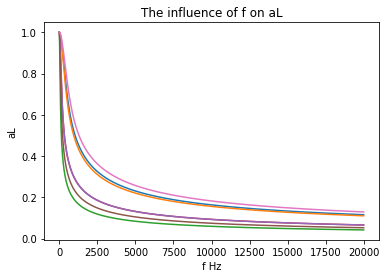

In [18]:
y1=aLch[:,0]
y2=aLch[:,1]
y3=aLch[:,2]
y4=aLch[:,3]
y5=aLch[:,4]
y6=aLch[:,5]
y7=aLch[:,6]

plt.xlabel('f Hz')
plt.ylabel('aL')
plt.title('The influence of f on aL')
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)
plt.plot(x,y5)
plt.plot(x,y6)
plt.plot(x,y7)
plt.show()

## 频率变化对阻抗的影响

In [19]:
def calc_fch(fch):
    a=np.shape(fch)[0]
    b=np.shape(Z)[0]#H矩阵的列数，6
    H=np.empty((a,b),np.complex128)
    Lch=np.empty((a,b),np.float64)

    for i in range(a):
        for j in range(b):
            R,X,z=calc_z(fch[i],c_xy,r,Re,rou)
#             z=merge_z(z,0,1) 
#             z=merge_z(z,2,3)
#             z=merge_z(z,2,3)
#             z=merge_z(z,2,3)
#             z=merge_z(z,3,4)
#             z=merge_z(z,5,6)
#             z=merge_z(z,5,6)
#             z=merge_z(z,5,6)
            Pm1=z
            Pm1[:,13]=Pm1[:,13]-Pm1[:,10]
            Pm1[:,12]=Pm1[:,12]-Pm1[:,10]
            Pm1[:,11]=Pm1[:,11]-Pm1[:,10]
            # '''第二步：列归并'''
            Pm1[13,:]=Pm1[13,:]-Pm1[10,:]
            Pm1[12,:]=Pm1[12,:]-Pm1[10,:]
            Pm1[11,:]=Pm1[11,:]-Pm1[10,:]
            # '''分块'''
            PLL1=np.mat(Pm1[0:11,0:11])
            PLT1=np.mat(Pm1[0:11,11:14])
            PTL1=np.mat(Pm1[11:14,0:11])
            PTT1=np.mat(Pm1[11:14,11:14])
            # print(np.shape(PTT1))
            # print(np.shape(PTL1))
#             print(np.shape(PLT1))
#             print(np.shape(PLL1))
            #p11 = np.linalg.inv(PTT1)
            #print('P11:',P11.shape,P11.type)
            #print('PLT1:',PLT1.shape)
            # p22 = PLT1*p11
            #p22 = PLT1*p11
            #print('p22:',p22.shape)
            Pm2=PLL1-PLT1*np.linalg.inv(PTT1)*PTL1

            # '''归并2：MW2承力索2，CW2接触线2，两根导线归并为1根
            # 第一步'''
            Pm2[:,8]=Pm2[:,8]-Pm2[:,7]
            # '''第二步'''
            Pm2[8,:]=Pm2[8,:]-Pm2[7,:]
            # '''分块'''
            PLL2u=np.mat(np.hstack((Pm2[0:8,0:8],Pm2[0:8,9:11])))
            PLL2d=np.mat(np.hstack((Pm2[9:11,0:8],Pm2[9:11,9:11])))
            PLL2=np.mat(np.vstack((PLL2u,PLL2d)))
            #PLT2=Pm2[[0:7,9:10],8]
            PLT2=np.mat(np.vstack((Pm2[0:8,8],Pm2[9:11,8])))
            #PTL2=Pm2[8,[0:7,9:10]]
            PTL2=np.mat(np.hstack((Pm2[8,0:8],Pm2[8,9:11])))
            PTT2=np.mat(Pm2[8,8])
            Pm3=PLL2-PLT2*np.linalg.inv(PTT2)*PTL2#第二次合并完成（10×10）

            # '''归并3：PW1保护线1，RR1钢轨1右，RL1钢轨1左，CGW1综合地线1，四根导线归并为1根
            # 第一步'''
            Pm3[:,4]=Pm3[:,4]-Pm3[:,3]
            Pm3[:,5]=Pm3[:,5]-Pm3[:,3]
            Pm3[:,6]=Pm3[:,6]-Pm3[:,3]
            #第二步
            Pm3[4,:]=Pm3[4,:]-Pm3[3,:]
            Pm3[5,:]=Pm3[5,:]-Pm3[3,:]
            Pm3[6,:]=Pm3[6,:]-Pm3[3,:]
            #分块
            PLL3u=np.mat(np.hstack((Pm3[0:4,0:4],Pm3[0:4,7:10])))
            PLL3d=np.mat(np.hstack((Pm3[7:10,0:4],Pm3[7:10,7:10])))
            PLL3=np.mat(np.vstack((PLL3u,PLL3d)))
            PLT3=np.mat(np.vstack((Pm3[0:4,4:7],Pm3[7:10,4:7])))
            PTL3=np.mat(np.hstack((Pm3[4:7,0:4],Pm3[4:7,7:10])))
            PTT3=np.mat(Pm3[4:7,4:7])
            Pm4=PLL3-PLT3*np.linalg.inv(PTT3)*PTL3#第三次合并完成（7×7）

            # '''归并4：MW1承力索1，CW1接触线1，两根导线归并为1根
            # 第一步'''
            Pm4[:,1]=Pm4[:,1]-Pm4[:,0]
            # '''第二步'''
            Pm4[1,:]=Pm4[1,:]-Pm4[0,:]
            type(Pm4[0,2:7])
            # '''分块'''
            PLL4u=np.mat(np.hstack((np.mat(Pm4[0,0]),Pm4[0,2:7])))

            PLL4d=np.mat(np.hstack((Pm4[2:7,0],Pm4[2:7,2:7])))
            PLL4=np.mat(np.vstack((PLL4u,PLL4d)))
            PLT4=np.mat(np.vstack((np.mat(Pm4[0,1]),Pm4[2:7,1])))
            PTL4=np.mat(np.hstack((np.mat(Pm4[1,0]),Pm4[1,2:7])))
            PTT4=np.mat(Pm4[1,1])
            Pm=PLL4-PLT4*np.linalg.inv(PTT4)*PTL4#第二次合并完成（6×6）
            z=np.array(Pm)
            
            H[i][j]=z[j][j]
    Zch=np.abs(H)
    Rch=np.real(H)
    Xch=np.imag(H)

    for i in range(a):
        for j in range(b):
            w=2*np.pi*fch[i]
            Lch[i][j]=Xch[i][j]/w
    return H,Rch,Lch,Xch,Zch
fch=x1
H,Rch,Lch,Xch,Zch=calc_fch(fch)
print('H 矩阵 : \n {}'.format(H))
print('Lch 矩阵 : \n {}'.format(Lch))
print('Rch矩阵 : \n {}'.format(Rch))
print('Xch矩阵 : \n {}'.format(Xch))
print('Zch矩阵 : \n {}'.format(Zch))


H 矩阵 : 
 [[ 0.0804 +0.0102j  0.247  +0.0099j  0.0714 +0.0094j  0.0804 +0.0102j  0.247  +0.0099j  0.0714 +0.0094j]
 [ 0.0905 +0.0962j  0.2591 +0.0922j  0.0818 +0.0865j  0.0905 +0.0962j  0.2591 +0.0922j  0.0818 +0.0865j]
 [ 0.101  +0.175j   0.2748 +0.1677j  0.0929 +0.1564j  0.101  +0.175j   0.2748 +0.1677j  0.0929 +0.1564j]
 ...
 [19.8782+87.0698j 20.4735+52.4992j 19.9476+59.1558j 19.8782+87.0698j 20.4735+52.4992j 19.9476+59.1558j]
 [19.888 +87.1078j 20.483 +52.5207j 19.9574+59.1798j 19.888 +87.1078j 20.483 +52.5207j 19.9574+59.1798j]
 [19.8978+87.1457j 20.4925+52.5422j 19.9671+59.2037j 19.8978+87.1457j 20.4925+52.5422j 19.9671+59.2037j]]
Lch 矩阵 : 
 [[0.0016 0.0016 0.0015 0.0016 0.0016 0.0015]
 [0.0014 0.0013 0.0013 0.0014 0.0013 0.0013]
 [0.0013 0.0013 0.0012 0.0013 0.0013 0.0012]
 ...
 [0.0007 0.0004 0.0005 0.0007 0.0004 0.0005]
 [0.0007 0.0004 0.0005 0.0007 0.0004 0.0005]
 [0.0007 0.0004 0.0005 0.0007 0.0004 0.0005]]
Rch矩阵 : 
 [[ 0.0804  0.247   0.0714  0.0804  0.247   0.0714]
 [ 0.09

* f对R的影响

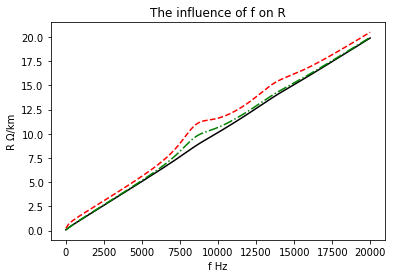

In [20]:
import matplotlib.pyplot as plt
def draw_R(fch):
    x=fch
    y1=Rch[:,0]
    y2=Rch[:,1]
    y3=Rch[:,2]
    y4=Rch[:,3]
    y5=Rch[:,4]
    y6=Rch[:,5]
    #my_x_ticks = np.arange(0, 100, 10)

    plt.xlabel('f Hz')
    plt.ylabel('R Ω/km')
    plt.title('The influence of f on R')


    #my_x_ticks=np.arange(0,100000,1000)
    #my_y_ticks=np.arange(0,1.5,0.1)
    #plt.xticks(my_x_ticks)
    #plt.yticks(my_y_ticks)
    plt.rcParams['figure.figsize']=(8.0,4.0)


    R1=plt.plot(x,y1,color='black')
    R2=plt.plot(x,y2,color='red',ls='--')
    R3=plt.plot(x,y3,color='green',ls='-.')
#     R4=plt.plot(x,y4,color='blue')
#     R5=plt.plot(x,y5,color='orange')
#     R6=plt.plot(x,y6,color='purple')
#    return R1,R2,R3,R4,R5,R6
    return R1,R2,R3
    #plt.figure(figsize=(1, 8)) 
x=x1
R1,R2,R3=draw_R(fch)
#R1,R2,R3,R4,R5,R6=draw_R(fch)
plt.show()

* f对L的影响

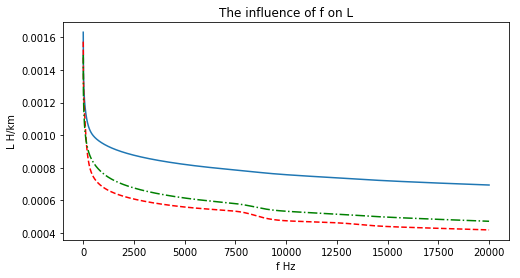

In [21]:
def draw_L(fch):
    x=fch
    y1=Lch[:,0]
    y2=Lch[:,1]
    y3=Lch[:,2]
    y4=Lch[:,3]
    y5=Lch[:,4]
    y6=Lch[:,5]

    plt.xlabel('f Hz')
    plt.ylabel('L H/km')
    plt.title('The influence of f on L')

    L1=plt.plot(x,y1)
    L2=plt.plot(x,y2,color='red',ls='--')
    L3=plt.plot(x,y3,color='green',ls='-.')
#     L4=plt.plot(x,y4,color='blue')
#     L5=plt.plot(x,y5,color='orange',ls='--')
#     L6=plt.plot(x,y6,color='purple',ls='-.')
    #Legend=plt.legend(handles = [L1,L2,L3], labels = ['L1''L2','L3'])
#    return L1,L2,L3,L4,L5,L6
    return L1,L2,L3
x=x1
L1,L2,L3=draw_L(fch)
plt.show()

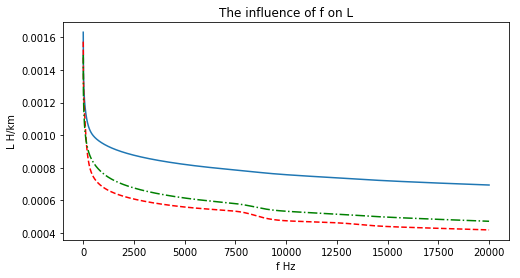

In [22]:
def draw_L(fch):
    x=fch
    y1=Lch[:,0]
    y2=Lch[:,1]
    y3=Lch[:,2]
    y4=Lch[:,3]
    y5=Lch[:,4]
    y6=Lch[:,5]

    plt.xlabel('f Hz')
    plt.ylabel('L H/km')
    plt.title('The influence of f on L')

    L1=plt.plot(x,y1)
    L2=plt.plot(x,y2,color='red',ls='--')
    L3=plt.plot(x,y3,color='green',ls='-.')
#     L4=plt.plot(x,y4,color='blue')
#     L5=plt.plot(x,y5,color='orange',ls='--')
#     L6=plt.plot(x,y6,color='purple',ls='-.')
    #Legend=plt.legend(handles = [L1,L2,L3], labels = ['L1''L2','L3'])
#    return L1,L2,L3,L4,L5,L6
    return L1,L2,L3
x=x1
L1,L2,L3=draw_L(fch)
plt.show()


    f对X的影响



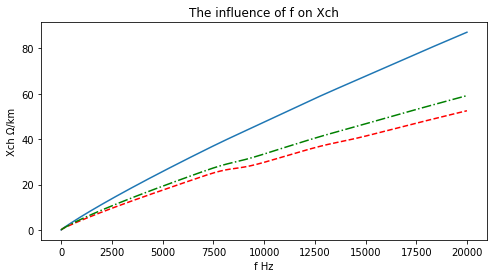

In [23]:
def draw_X(fch):
    x=fch
    y1=Xch[:,0]
    y2=Xch[:,1]
    y3=Xch[:,2]
    y4=Xch[:,3]
    y5=Xch[:,4]
    y6=Xch[:,5]

    plt.xlabel('f Hz')
    plt.ylabel('Xch Ω/km')
    plt.title('The influence of f on Xch')
    X1=plt.plot(x,y1)
    X2=plt.plot(x,y2,color='red',ls='--')
    X3=plt.plot(x,y3,color='green',ls='-.')
#     X4=plt.plot(x,y4,color='blue')
#     X5=plt.plot(x,y5,color='orange',ls='--')
#     X6=plt.plot(x,y6,color='purple',ls='-.')
#    return X1,X2,X3,X4,X5,X6
    return X1,X2,X3
x1=fch
X1,X2,X3=draw_X(fch)
plt.show()

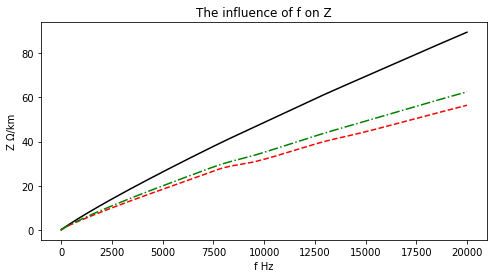

In [24]:
def draw_Z(fch):
    x=fch
    y1=Zch[:,0]
    y2=Zch[:,1]
    y3=Zch[:,2]
    y4=Zch[:,3]
    y5=Zch[:,4]
    y6=Zch[:,5]
    #my_x_ticks = np.arange(0, 100, 10)

    plt.xlabel('f Hz')
    plt.ylabel('Z Ω/km')
    plt.title('The influence of f on Z')


    #my_x_ticks=np.arange(0,100000,1000)
    #my_y_ticks=np.arange(0,1.5,0.1)
    #plt.xticks(my_x_ticks)
    #plt.yticks(my_y_ticks)
    plt.rcParams['figure.figsize']=(8.0,4.0)


    Z1=plt.plot(x,y1,color='black')
    Z2=plt.plot(x,y2,color='red',ls='--')
    Z3=plt.plot(x,y3,color='green',ls='-.')
#     R4=plt.plot(x,y4,color='blue')
#     R5=plt.plot(x,y5,color='orange')
#     R6=plt.plot(x,y6,color='purple')
#    return R1,R2,R3,R4,R5,R6
    return Z1,Z2,Z3
    #plt.figure(figsize=(1, 8)) 
x=x1
Z1,Z2,Z3=draw_Z(fch)
#R1,R2,R3,R4,R5,R6=draw_R(fch)
plt.show()

## 6. 导线复杂计算阻抗 ##
** calc_z1(f,c_xy,r,re,rou) **
* Parameters:
    1. f:       频率（Hz）
    2. c_xy:     2×n维数组，多导线的坐标（x,y）,单位（m）; 
    3. r:       1×n维数组导线，等效半径（m）
    4. re       1×n维数组，导线电阻
    5. rou      大地电阻率（Ω/m）
    6. rho     导线电阻率（Ω/m）
    7. L:       n×n维数组，理想导体时的电感
    8. Zc：      1×n维数组，导线内电阻和内电感（Ω/km）
    9. Zg：      n×n维数组，大地内阻抗（Ω/km）  
* Return:
     z1 :      n×n维数组，复杂方法计算得到的阻抗矩阵（Ω/km）
    

In [25]:
def calc_z1(c_xy,r,f,rou):
    n=np.shape(c_xy)[0]
    z1=np.empty((n,n),np.complex128)
    L=calc_L(c_xy,r)
    aR,aL=calc_aRaL(f,r)
    for i in range(n):
        for j in range(n):
            Dij=np.sqrt((c_xy[i,0]-c_xy[j,0])**2+(c_xy[i,1]+c_xy[j,1])**2)
            xij=np.abs(c_xy[i,0]-c_xy[j,0])
            theta=np.arcsin(xij/Dij)
            k=4*np.pi*np.sqrt(5)*10**-4*Dij*np.sqrt(f/rou)
            Rg=calc_Rg(f,k,theta)
            Xg=calc_Xg(f,k,theta)
            if i==j:
                z1[i,i]=1j*2*np.pi*f*L[i,i]+aR[i]*rd[i]+1j*np.pi*f*10**-7*aL[i]+Rg+1j*Xg
            else:
                z1[i,j]=1j*2*np.pi*f*L[i,j]+Rg+1j*Xg
    return z1
    
f=50
rou=100
rd=conductors_resistance
c_xy=conductors_coordinater
z1=calc_z1(c_xy,r,f,rou)
print(z1)

[[0.197 +0.2709j 0.0493+0.2648j 0.0493+0.2577j 0.0493+0.3044j 0.0493+0.3044j 0.0493+0.2606j 0.0493+0.2982j 0.0493+0.2659j 0.0493+0.2609j 0.0493+0.2497j 0.0493+0.2955j 0.0493+0.2895j 0.0493+0.2528j 0.0493+0.2756j]
 [0.0493+0.2648j 0.2095+0.26j   0.0493+0.2532j 0.0493+0.2949j 0.0493+0.2949j 0.0493+0.2558j 0.0493+0.2906j 0.0493+0.2609j 0.0493+0.2562j 0.0493+0.2461j 0.0493+0.2881j 0.0493+0.2833j 0.0493+0.249j  0.0493+0.2717j]
 [0.0493+0.2577j 0.0493+0.2532j 0.2849+0.2521j 0.0493+0.2838j 0.0493+0.28j   0.0493+0.2536j 0.0493+0.2915j 0.0493+0.2497j 0.0493+0.2461j 0.0493+0.2357j 0.0493+0.2692j 0.0493+0.2642j 0.0493+0.2383j 0.0493+0.2535j]
 [0.0493+0.3044j 0.0493+0.2949j 0.0493+0.2838j 0.1982+0.3863j 0.0493+0.3719j 0.0493+0.2886j 0.0493+0.3434j 0.0493+0.2895j 0.0493+0.2833j 0.0493+0.2642j 0.0493+0.3238j 0.0493+0.3091j 0.0493+0.2685j 0.0493+0.2833j]
 [0.0493+0.3044j 0.0493+0.2949j 0.0493+0.28j   0.0493+0.3719j 0.1982+0.3863j 0.0493+0.2849j 0.0493+0.324j  0.0493+0.2955j 0.0493+0.2881j 0.0493+0.26

In [26]:
print(z1)
# z1=merge_z(z1,0,1) 
# z1=merge_z(z1,2,3)
# z1=merge_z(z1,2,3)
# z1=merge_z(z1,2,3)
# z1=merge_z(z1,3,4)
# z1=merge_z(z1,5,6)
# z1=merge_z(z1,5,6)
# z1=merge_z(z1,5,6)
Pm1=z1
# print(z1.shape)
# print(Pm1.shape)
Pm1[:,13]=Pm1[:,13]-Pm1[:,10]
Pm1[:,12]=Pm1[:,12]-Pm1[:,10]
Pm1[:,11]=Pm1[:,11]-Pm1[:,10]
# '''第二步：列归并'''
Pm1[13,:]=Pm1[13,:]-Pm1[10,:]
Pm1[12,:]=Pm1[12,:]-Pm1[10,:]
Pm1[11,:]=Pm1[11,:]-Pm1[10,:]
# '''分块'''
PLL1=np.mat(Pm1[0:11,0:11])
PLT1=np.mat(Pm1[0:11,11:14])
PTL1=np.mat(Pm1[11:14,0:11])
PTT1=np.mat(Pm1[11:14,11:14])
# print(np.shape(PTT1))
# print(np.shape(PTL1))
#             print(np.shape(PLT1))
#             print(np.shape(PLL1))
#p11 = np.linalg.inv(PTT1)
#print('P11:',P11.shape,P11.type)
#print('PLT1:',PLT1.shape)
# p22 = PLT1*p11
#p22 = PLT1*p11
#print('p22:',p22.shape)
Pm2=PLL1-PLT1*np.linalg.inv(PTT1)*PTL1

# '''归并2：MW2承力索2，CW2接触线2，两根导线归并为1根
# 第一步'''
Pm2[:,8]=Pm2[:,8]-Pm2[:,7]
# '''第二步'''
Pm2[8,:]=Pm2[8,:]-Pm2[7,:]
# '''分块'''
PLL2u=np.mat(np.hstack((Pm2[0:8,0:8],Pm2[0:8,9:11])))
PLL2d=np.mat(np.hstack((Pm2[9:11,0:8],Pm2[9:11,9:11])))
PLL2=np.mat(np.vstack((PLL2u,PLL2d)))
#PLT2=Pm2[[0:7,9:10],8]
PLT2=np.mat(np.vstack((Pm2[0:8,8],Pm2[9:11,8])))
#PTL2=Pm2[8,[0:7,9:10]]
PTL2=np.mat(np.hstack((Pm2[8,0:8],Pm2[8,9:11])))
PTT2=np.mat(Pm2[8,8])
Pm3=PLL2-PLT2*np.linalg.inv(PTT2)*PTL2#第二次合并完成（10×10）

# '''归并3：PW1保护线1，RR1钢轨1右，RL1钢轨1左，CGW1综合地线1，四根导线归并为1根
# 第一步'''
Pm3[:,4]=Pm3[:,4]-Pm3[:,3]
Pm3[:,5]=Pm3[:,5]-Pm3[:,3]
Pm3[:,6]=Pm3[:,6]-Pm3[:,3]
#第二步
Pm3[4,:]=Pm3[4,:]-Pm3[3,:]
Pm3[5,:]=Pm3[5,:]-Pm3[3,:]
Pm3[6,:]=Pm3[6,:]-Pm3[3,:]
#分块
PLL3u=np.mat(np.hstack((Pm3[0:4,0:4],Pm3[0:4,7:10])))
PLL3d=np.mat(np.hstack((Pm3[7:10,0:4],Pm3[7:10,7:10])))
PLL3=np.mat(np.vstack((PLL3u,PLL3d)))
PLT3=np.mat(np.vstack((Pm3[0:4,4:7],Pm3[7:10,4:7])))
PTL3=np.mat(np.hstack((Pm3[4:7,0:4],Pm3[4:7,7:10])))
PTT3=np.mat(Pm3[4:7,4:7])
Pm4=PLL3-PLT3*np.linalg.inv(PTT3)*PTL3#第三次合并完成（7×7）

# '''归并4：MW1承力索1，CW1接触线1，两根导线归并为1根
# 第一步'''
Pm4[:,1]=Pm4[:,1]-Pm4[:,0]
# '''第二步'''
Pm4[1,:]=Pm4[1,:]-Pm4[0,:]
type(Pm4[0,2:7])
# '''分块'''
PLL4u=np.mat(np.hstack((np.mat(Pm4[0,0]),Pm4[0,2:7])))

PLL4d=np.mat(np.hstack((Pm4[2:7,0],Pm4[2:7,2:7])))
PLL4=np.mat(np.vstack((PLL4u,PLL4d)))
PLT4=np.mat(np.vstack((np.mat(Pm4[0,1]),Pm4[2:7,1])))
PTL4=np.mat(np.hstack((np.mat(Pm4[1,0]),Pm4[1,2:7])))
PTT4=np.mat(Pm4[1,1])
Pm=PLL4-PLT4*np.linalg.inv(PTT4)*PTL4#第二次合并完成（6×6）
z1=np.array(Pm)
Z1=np.abs(z1)
#z1m=z1
np.set_printoptions(precision=4,linewidth=214,suppress=True)              
print('阻抗矩阵z1m（Ω/km）: \n {}'.format(z1))
print('阻抗矩阵模Z1m（Ω/km）: \n {}'.format(Z1))

[[0.197 +0.2709j 0.0493+0.2648j 0.0493+0.2577j 0.0493+0.3044j 0.0493+0.3044j 0.0493+0.2606j 0.0493+0.2982j 0.0493+0.2659j 0.0493+0.2609j 0.0493+0.2497j 0.0493+0.2955j 0.0493+0.2895j 0.0493+0.2528j 0.0493+0.2756j]
 [0.0493+0.2648j 0.2095+0.26j   0.0493+0.2532j 0.0493+0.2949j 0.0493+0.2949j 0.0493+0.2558j 0.0493+0.2906j 0.0493+0.2609j 0.0493+0.2562j 0.0493+0.2461j 0.0493+0.2881j 0.0493+0.2833j 0.0493+0.249j  0.0493+0.2717j]
 [0.0493+0.2577j 0.0493+0.2532j 0.2849+0.2521j 0.0493+0.2838j 0.0493+0.28j   0.0493+0.2536j 0.0493+0.2915j 0.0493+0.2497j 0.0493+0.2461j 0.0493+0.2357j 0.0493+0.2692j 0.0493+0.2642j 0.0493+0.2383j 0.0493+0.2535j]
 [0.0493+0.3044j 0.0493+0.2949j 0.0493+0.2838j 0.1982+0.3863j 0.0493+0.3719j 0.0493+0.2886j 0.0493+0.3434j 0.0493+0.2895j 0.0493+0.2833j 0.0493+0.2642j 0.0493+0.3238j 0.0493+0.3091j 0.0493+0.2685j 0.0493+0.2833j]
 [0.0493+0.3044j 0.0493+0.2949j 0.0493+0.28j   0.0493+0.3719j 0.1982+0.3863j 0.0493+0.2849j 0.0493+0.324j  0.0493+0.2955j 0.0493+0.2881j 0.0493+0.26

## 频率变化对复杂方法阻抗矩阵的影响

In [27]:

def calc_fch1(fch):
    a=np.shape(fch)[0]
    b=np.shape(Z1)[0]#H矩阵的列数，6
    H1=np.empty((a,b),np.complex64)
    Lch1=np.empty((a,b),np.float64)

    for i in range(a):
        for j in range(b):
            z1=calc_z1(c_xy,r,fch[i],rou)
#             z1=merge_z(z1,0,1) 
#             z1=merge_z(z1,2,3)
#             z1=merge_z(z1,2,3)
#             z1=merge_z(z1,2,3)
#             z1=merge_z(z1,3,4)
#             z1=merge_z(z1,5,6)
#             z1=merge_z(z1,5,6)
#             z1=merge_z(z1,5,6)
#             z1=merge_z(z1,0,1) 
#             z1=merge_z(z1,6,7)
#             z1=merge_z(z1,2,3)
#             z1=merge_z(z1,7,8)
#             z1=merge_z(z1,2,3)
#             z1=merge_z(z1,6,7)
#             z1=merge_z(z1,2,3)
#             z1=merge_z(z1,5,6)
            Pm1=z1
            Pm1[:,13]=Pm1[:,13]-Pm1[:,10]
            Pm1[:,12]=Pm1[:,12]-Pm1[:,10]
            Pm1[:,11]=Pm1[:,11]-Pm1[:,10]
            # '''第二步：列归并'''
            Pm1[13,:]=Pm1[13,:]-Pm1[10,:]
            Pm1[12,:]=Pm1[12,:]-Pm1[10,:]
            Pm1[11,:]=Pm1[11,:]-Pm1[10,:]
            # '''分块'''
            PLL1=np.mat(Pm1[0:11,0:11])
            PLT1=np.mat(Pm1[0:11,11:14])
            PTL1=np.mat(Pm1[11:14,0:11])
            PTT1=np.mat(Pm1[11:14,11:14])
            # print(np.shape(PTT1))
            # print(np.shape(PTL1))
#             print(np.shape(PLT1))
#             print(np.shape(PLL1))
            #p11 = np.linalg.inv(PTT1)
            #print('P11:',P11.shape,P11.type)
            #print('PLT1:',PLT1.shape)
            # p22 = PLT1*p11
            #p22 = PLT1*p11
            #print('p22:',p22.shape)
            Pm2=PLL1-PLT1*np.linalg.inv(PTT1)*PTL1

            # '''归并2：MW2承力索2，CW2接触线2，两根导线归并为1根
            # 第一步'''
            Pm2[:,8]=Pm2[:,8]-Pm2[:,7]
            # '''第二步'''
            Pm2[8,:]=Pm2[8,:]-Pm2[7,:]
            # '''分块'''
            PLL2u=np.mat(np.hstack((Pm2[0:8,0:8],Pm2[0:8,9:11])))
            PLL2d=np.mat(np.hstack((Pm2[9:11,0:8],Pm2[9:11,9:11])))
            PLL2=np.mat(np.vstack((PLL2u,PLL2d)))
            #PLT2=Pm2[[0:7,9:10],8]
            PLT2=np.mat(np.vstack((Pm2[0:8,8],Pm2[9:11,8])))
            #PTL2=Pm2[8,[0:7,9:10]]
            PTL2=np.mat(np.hstack((Pm2[8,0:8],Pm2[8,9:11])))
            PTT2=np.mat(Pm2[8,8])
            Pm3=PLL2-PLT2*np.linalg.inv(PTT2)*PTL2#第二次合并完成（10×10）

            # '''归并3：PW1保护线1，RR1钢轨1右，RL1钢轨1左，CGW1综合地线1，四根导线归并为1根
            # 第一步'''
            Pm3[:,4]=Pm3[:,4]-Pm3[:,3]
            Pm3[:,5]=Pm3[:,5]-Pm3[:,3]
            Pm3[:,6]=Pm3[:,6]-Pm3[:,3]
            #第二步
            Pm3[4,:]=Pm3[4,:]-Pm3[3,:]
            Pm3[5,:]=Pm3[5,:]-Pm3[3,:]
            Pm3[6,:]=Pm3[6,:]-Pm3[3,:]
            #分块
            PLL3u=np.mat(np.hstack((Pm3[0:4,0:4],Pm3[0:4,7:10])))
            PLL3d=np.mat(np.hstack((Pm3[7:10,0:4],Pm3[7:10,7:10])))
            PLL3=np.mat(np.vstack((PLL3u,PLL3d)))
            PLT3=np.mat(np.vstack((Pm3[0:4,4:7],Pm3[7:10,4:7])))
            PTL3=np.mat(np.hstack((Pm3[4:7,0:4],Pm3[4:7,7:10])))
            PTT3=np.mat(Pm3[4:7,4:7])
            Pm4=PLL3-PLT3*np.linalg.inv(PTT3)*PTL3#第三次合并完成（7×7）

            # '''归并4：MW1承力索1，CW1接触线1，两根导线归并为1根
            # 第一步'''
            Pm4[:,1]=Pm4[:,1]-Pm4[:,0]
            # '''第二步'''
            Pm4[1,:]=Pm4[1,:]-Pm4[0,:]
            type(Pm4[0,2:7])
            # '''分块'''
            PLL4u=np.mat(np.hstack((np.mat(Pm4[0,0]),Pm4[0,2:7])))

            PLL4d=np.mat(np.hstack((Pm4[2:7,0],Pm4[2:7,2:7])))
            PLL4=np.mat(np.vstack((PLL4u,PLL4d)))
            PLT4=np.mat(np.vstack((np.mat(Pm4[0,1]),Pm4[2:7,1])))
            PTL4=np.mat(np.hstack((np.mat(Pm4[1,0]),Pm4[1,2:7])))
            PTT4=np.mat(Pm4[1,1])
            Pm=PLL4-PLT4*np.linalg.inv(PTT4)*PTL4#第二次合并完成（6×6）
            z1=np.array(Pm)
            H1[i][j]=z1[j][j]
    Zch1=np.abs(H1)
    Rch1=np.real(H1)
    Xch1=np.imag(H1)

    for i in range(a):
        for j in range(b):
            w=2*np.pi*fch[i]
            Lch1[i][j]=Xch1[i][j]/w
    return H1,Rch1,Lch1,Xch1,Zch1
fch=x1
aRch,aLch=calc_aRaLch(fch)
aR=aRch
aL=aLch
H1,Rch1,Lch1,Xch1,Zch1=calc_fch1(fch)

# H1=np.nan_to_num(H1)
# Rch1=np.nan_to_num(Rch1)
# Lch1=np.nan_to_num(Lch1)
# Xch1=np.nan_to_num(Xch1)
# Zch1=np.nan_to_num(Zch1)
print('H 矩阵 : \n {}'.format(H1))
print('Lch 矩阵 : \n {}'.format(Lch1))
print('Rch矩阵 : \n {}'.format(Rch1))
print('Xch矩阵 : \n {}'.format(Xch1))
print('Zch矩阵 : \n {}'.format(Zch1))


H 矩阵 : 
 [[ 0.0769 +0.0078j  0.164  +0.0075j  0.0458 +0.0093j  0.0769 +0.0078j  0.164  +0.0075j  0.0458 +0.0093j]
 [ 0.0873 +0.0688j  0.1793 +0.0659j  0.0572 +0.0854j  0.0873 +0.0688j  0.1793 +0.0659j  0.0572 +0.0854j]
 [ 0.0985 +0.1227j  0.2024 +0.1172j  0.0707 +0.1542j  0.0985 +0.1227j  0.2024 +0.1172j  0.0707 +0.1542j]
 ...
 [26.1031+10.8483j 27.3804+12.3975j 34.0722+15.5055j 26.1031+10.8483j 27.3804+12.3975j 34.0722+15.5055j]
 [26.1148+10.8467j 27.3923+12.3969j 34.0863+15.5051j 26.1148+10.8467j 27.3923+12.3969j 34.0863+15.5051j]
 [26.1265+10.845j  27.4043+12.3963j 34.1004+15.5046j 26.1265+10.845j  27.4043+12.3963j 34.1004+15.5046j]]
Lch 矩阵 : 
 [[0.0012 0.0012 0.0015 0.0012 0.0012 0.0015]
 [0.001  0.001  0.0012 0.001  0.001  0.0012]
 [0.0009 0.0009 0.0012 0.0009 0.0009 0.0012]
 ...
 [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
 [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
 [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]]
Rch矩阵 : 
 [[ 0.0769  0.164   0.0458  0.0769  0.164   0.0458]
 [ 0.08

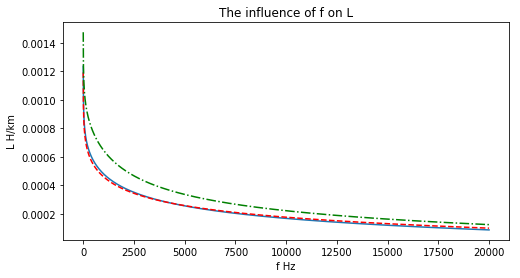

In [28]:
def draw_L(fch):
    x=fch
    y1=Lch1[:,0]
    y2=Lch1[:,1]
    y3=Lch1[:,2]
    y4=Lch1[:,3]
    y5=Lch1[:,4]
    y6=Lch1[:,5]

    plt.xlabel('f Hz')
    plt.ylabel('L H/km')
    plt.title('The influence of f on L')

    L1=plt.plot(x,y1)
    L2=plt.plot(x,y2,color='red',ls='--')
    L3=plt.plot(x,y3,color='green',ls='-.')
#     L4=plt.plot(x,y4,color='blue')
#     L5=plt.plot(x,y5,color='orange',ls='--')
#     L6=plt.plot(x,y6,color='purple',ls='-.')
    #Legend=plt.legend(handles = [L1,L2,L3], labels = ['L1''L2','L3'])
#    return L1,L2,L3,L4,L5,L6
    return L1,L2,L3
x=x1
L1,L2,L3=draw_L(fch)
plt.show()

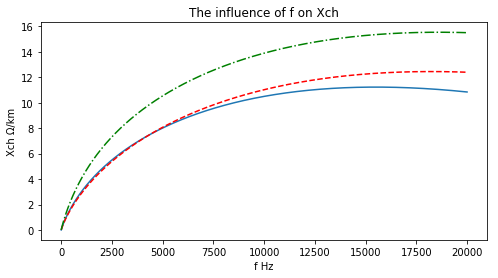

In [29]:
def draw_X(fch):
    x=fch
    y1=Xch1[:,0]
    y2=Xch1[:,1]
    y3=Xch1[:,2]
    y4=Xch1[:,3]
    y5=Xch1[:,4]
    y6=Xch1[:,5]

    plt.xlabel('f Hz')
    plt.ylabel('Xch Ω/km')
    plt.title('The influence of f on Xch')
    X1=plt.plot(x,y1)
    X2=plt.plot(x,y2,color='red',ls='--')
    X3=plt.plot(x,y3,color='green',ls='-.')
#     X4=plt.plot(x,y4,color='blue')
#     X5=plt.plot(x,y5,color='orange',ls='--')
#     X6=plt.plot(x,y6,color='purple',ls='-.')
#    return X1,X2,X3,X4,X5,X6
    return X1,X2,X3
x1=fch
X1,X2,X3=draw_X(fch)
plt.show()

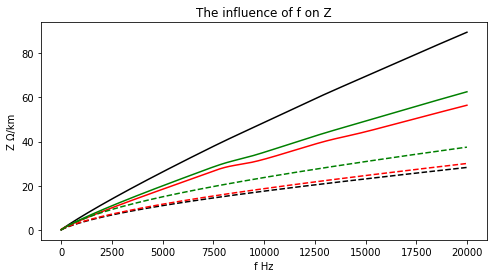

In [30]:
def draw_Z(fch):
    x=fch
    y1=Zch[:,0]
    y2=Zch[:,1]
    y3=Zch[:,2]
    y4=Zch1[:,0]
    y5=Zch1[:,4]
    y6=Zch1[:,2]
    

    plt.xlabel('f Hz')
    plt.ylabel('Z Ω/km')
    plt.title('The influence of f on Z')

    plt.rcParams['figure.figsize']=(8.0,4.0)


    Z1=plt.plot(x,y1,color='black')
    Z2=plt.plot(x,y2,color='red')
    Z3=plt.plot(x,y3,color='green')
    Zch2=plt.plot(x,y4,color='black',ls='--')
    Zch3=plt.plot(x,y5,color='red',ls='--')
    Zch4=plt.plot(x,y6,color='green',ls='--')

    return Z1,Z2,Z3,Zch2,Zch3,Zch4


Z1,Z2,Z3,Zch2,Zch3,Zch4=draw_Z(x1)

plt.show()